In [1]:
# IDEAS: 
# go by ova positoin instead of antibody and see if there are trends
# try to identify number of antibodies missed by all methods.
# see if all esm models make similar errors.
# see if all antibody pretrained models make similar errors.
# how would ensembling have done?

In [110]:
from collections import defaultdict
import itertools
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
from sklearn import metrics
import wandb

In [90]:
api = wandb.Api()
sweep = api.sweep("nickbhat/ova-perplexity/sweeps/smmy0s4z")
_d = []
for run in sweep.runs:
    metrics = run.history().to_dict()
    m = {k: v[0] for k, v in metrics.items()}
    cf = run.config
    _d.append({**m, **cf})
df = pd.DataFrame.from_dict(_d)

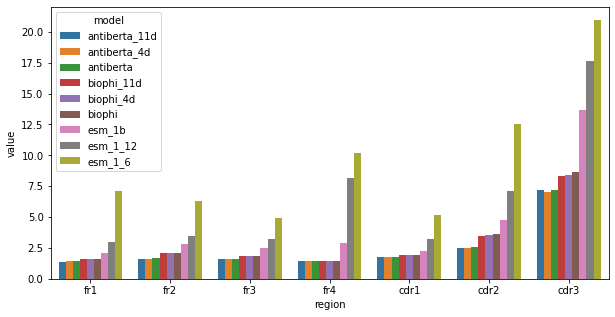

In [109]:
to_plot = df[(df.mask_inside=="false") & (df.mask_outside == "false")]
melted = pd.melt(
    to_plot, 
    id_vars = ["model"], 
    value_vars=["fr1", "fr2", "fr3", "fr4", "cdr1", "cdr2", "cdr3"],
)
melted = melted.rename(columns={"variable":"region"})
plt.figure(figsize=(10,5))
sns.barplot(x="region", y="value", hue="model", data=melted)
plt.savefig("pppl_v0.png")

In [98]:
to_plot.columns

Index(['fr2', 'fr1', '_step', 'cdr3', '_runtime', 'cdr1', 'fr4', 'fr3', 'cdr2',
       '_timestamp', 'model', 'mask_inside', 'mask_outside'],
      dtype='object')

In [102]:
test = pd.melt(
    to_plot, 
    id_vars = ["model"], 
    value_vars=["fr1", "fr2", "fr3", "fr4", "cdr1", "cdr2", "cdr3"],
)

<AxesSubplot:xlabel='variable', ylabel='value'>

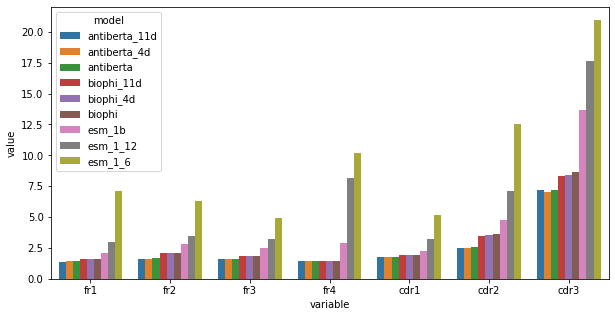

In [106]:
plt.figure(figsize=(10,5))
sns.barplot(x="variable", y="value", hue="model", data=test)

In [94]:
to_plot

,fr2,fr1,_step,cdr3,_runtime,cdr1,fr4,fr3,cdr2,_timestamp,model,mask_inside,mask_outside
27,1.592125,1.395849,0,7.189585,2682,1.761202,1.416069,1.572824,2.471888,1647515648,antiberta_11d,false,false
28,1.624034,1.419707,0,7.018082,2686,1.768745,1.403572,1.586337,2.488839,1647512956,antiberta_4d,false,false
29,1.680871,1.444917,0,7.220610,2690,1.792730,1.471808,1.624674,2.614248,1647510257,antiberta,false,false
30,2.068456,1.636028,0,8.309531,95,1.958004,1.467836,1.843576,3.494733,1647507560,biophi_11d,false,false
31,2.100235,1.638339,0,8.437829,95,1.952381,1.451680,1.849863,3.551701,1647507452,biophi_4d,false,false
32,2.126571,1.640731,0,8.650541,96,1.939742,1.455810,1.856203,3.617413,1647507345,biophi,false,false
33,2.850374,2.074203,0,13.708755,17386,2.239536,2.931965,2.466094,4.799553,1647507200,esm_1b,false,false
34,3.459846,2.940277,0,17.644640,3119,3.236852,8.132955,3.222371,7.094265,1647489805,esm_1_12,false,false
35,6.268930,7.147390,0,20.966193,1573,5.181439,10.225270,4.888271,12.546969,1647486673,esm_1_6,false,false


In [111]:
methods = [
    "aa_descriptor",
    "antiberta",
    "esm_1_12",
    "esm_1_6",
    "esm_1b",
    "onehot",
    "sapiens",
]
split_type = [
    "random",
    "seqid",
    "clonotype",
    "epitope",
]
agg = [
    "vanilla",
    "aho",
    "segment",
]
test_preds = {k: {k2: defaultdict(dict) for k2 in agg} for k in split_type}
test_trues = {k: {k2: defaultdict(dict) for k2 in agg} for k in split_type}
root = Path("ova/030922_sweep")
p1 = Path("test_pred_probs.npz")
p2 = Path("test_true_Y.npz")
for m, s, a in itertools.product(methods, split_type, agg):
    path = root / Path(f"{m}-{s}-{a}")
    with np.load(path / p1) as d:
        test_preds[s][a][m] = d["arr_0"]
    with np.load(path / p2) as d:
        test_trues[s][a][m] = d["arr_0"]

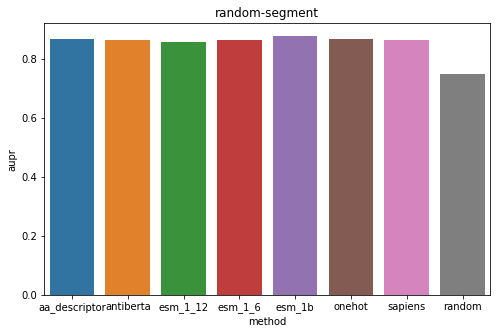

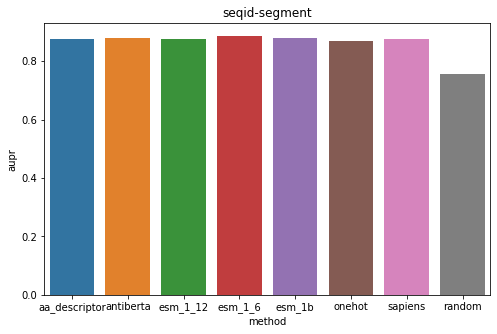

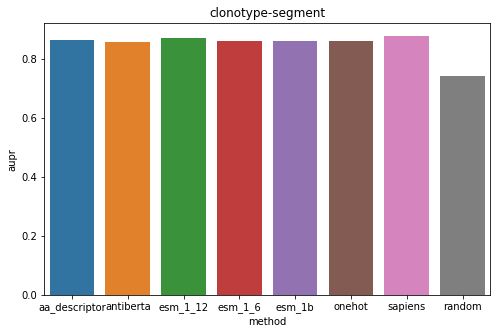

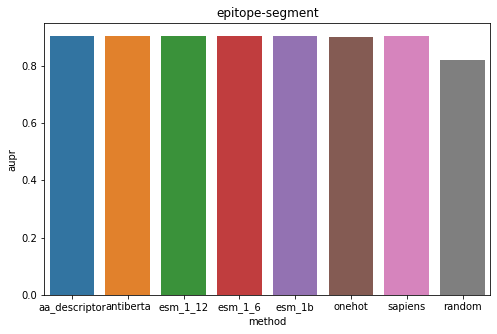

In [3]:
a = "segment"
for s in split_type:
    auprs = {}
    for m in methods:
        p = test_preds[s][a][m][1]
        Y = test_trues[s][a][m].astype(np.int32)
        score = metrics.average_precision_score(Y.flatten(), p.flatten())
        auprs[m] = score
    auprs["random"] = Y.sum() / len(Y.flatten())
    df = pd.DataFrame.from_dict(auprs, orient="index")
    df["method"] = df.index
    df["aupr"] = df[0]
    plt.figure(figsize=(8,5))
    plt.title(f"{s}-{a}")
    sns.barplot(x="method", y="aupr", data=df)
    plt.show()

In [33]:
local_scores = {}
for m in methods:
    p = test_preds["clonotype"]["segment"][m][1]
    Y = test_trues["clonotype"]["segment"][m]
    scores = [
        metrics.average_precision_score(Y_, p_) for Y_, p_ in zip(Y, p)
    ]
    local_scores[m] = scores 
    baseline = Y.sum(axis=1)/Y.shape[1]

df = pd.DataFrame.from_dict(local_scores, orient="index")

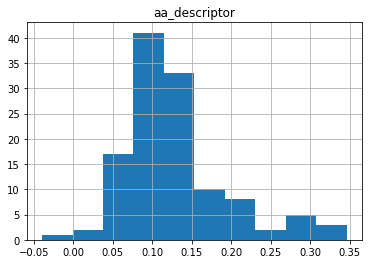

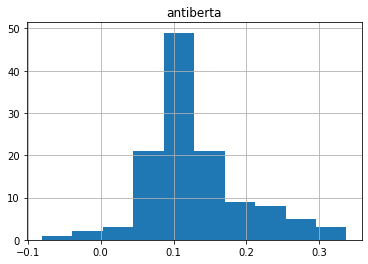

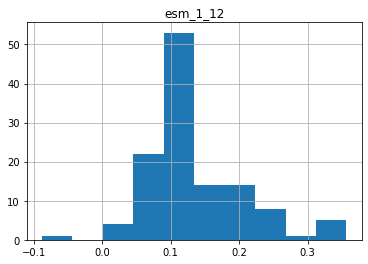

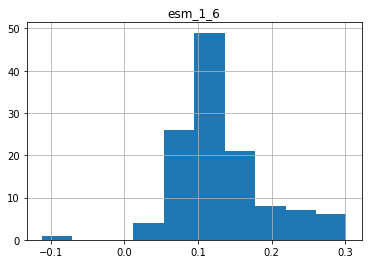

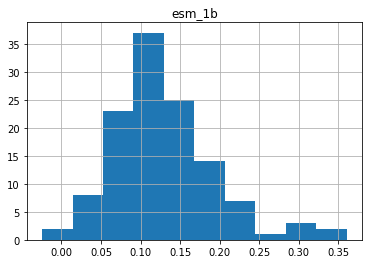

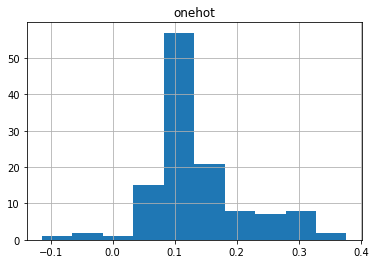

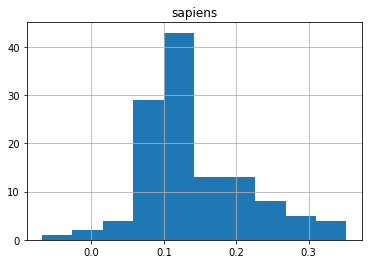

In [41]:
for name, row in df.iterrows():
    x = row - baseline
    plt.title(name)
    x.hist()
    plt.show()

In [6]:
x = df.median(axis=0)
q1 = df.quantile(0.9, axis=0)
q2 = df.quantile(0.1, axis=0)
y = q1 - q2
idx = np.where(x < 0.7)
idx2 = np.where(y > 0.1)

<AxesSubplot:>

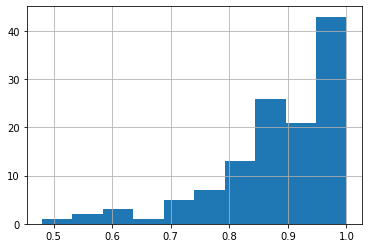

In [9]:
df.median(axis=0).hist()

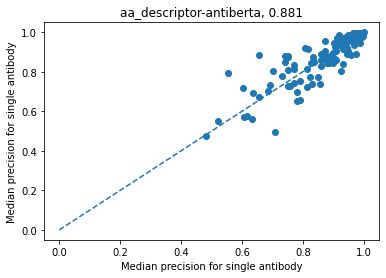

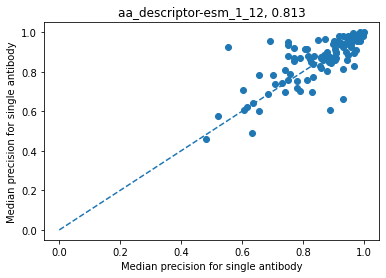

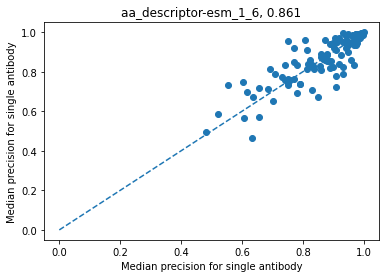

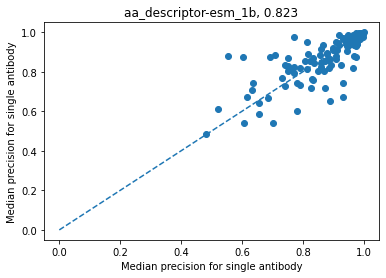

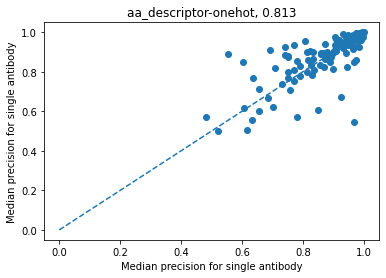

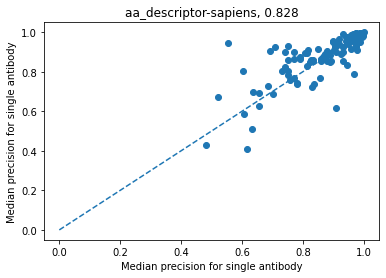

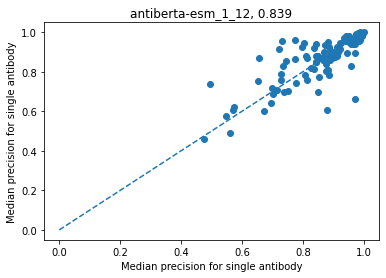

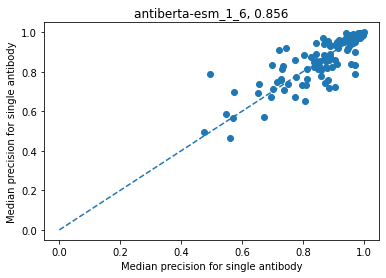

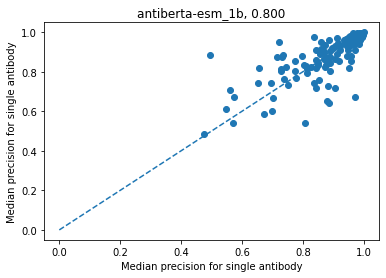

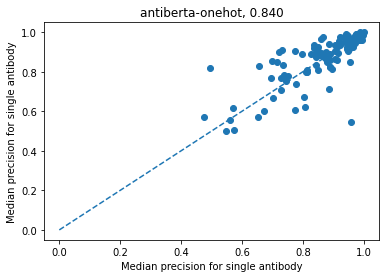

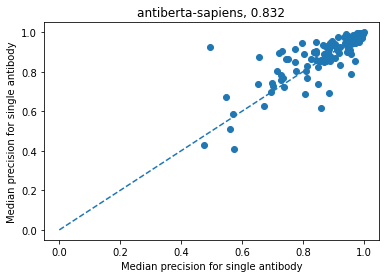

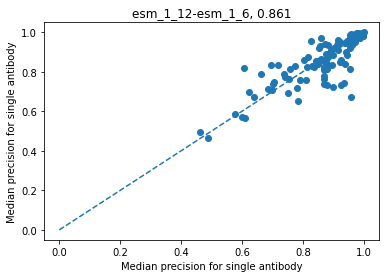

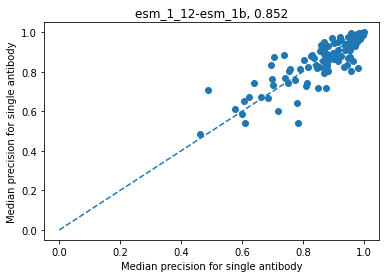

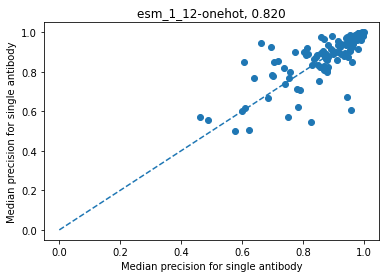

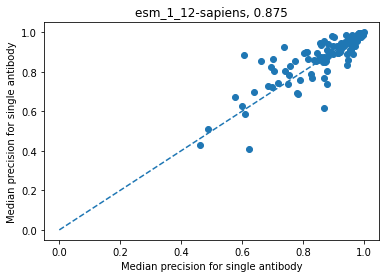

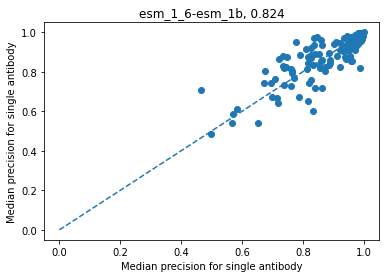

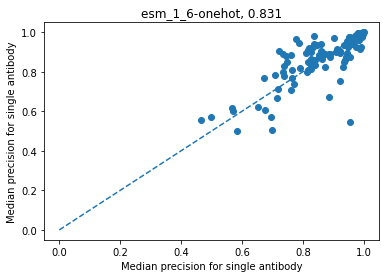

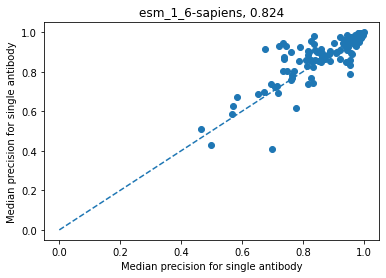

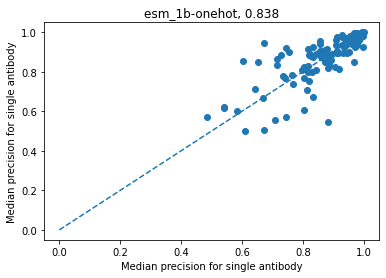

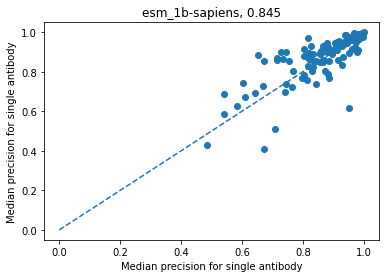

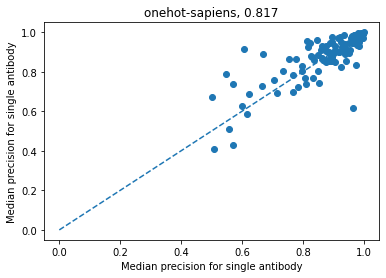

In [114]:
rhos = defaultdict(dict)
for m1, m2 in itertools.combinations(methods, 2):
    y1 = local_scores[m1]
    y2 = local_scores[m2]
    rho = scipy.stats.spearmanr(y1, y2)[0]
    rhos[m1][m1] = 1.0
    rhos[m1][m2] = rho
    plt.title(f"{m1}-{m2}, {rho:0.3f}")
    plt.scatter(y1, y2)
    plt.plot([0,1], [0,1], ls="--")
    plt.xlabel("Median precision for single antibody")
    plt.ylabel("Median precision for single antibody")
    plt.show()
rhos_df = pd.DataFrame.from_dict(rhos, orient="index")

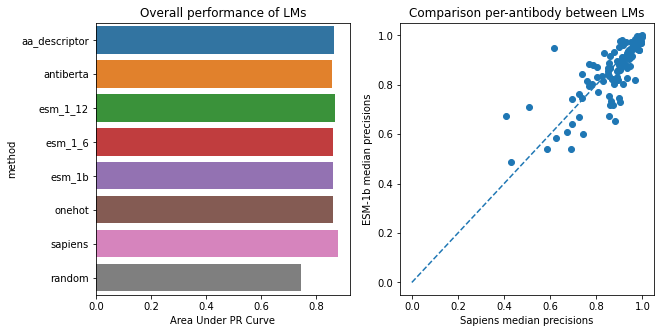

In [143]:
a = "segment"
s = "clonotype"

fig, axarr = plt.subplots(1, 2, figsize=(10,5))

auprs = {}
for m in methods:
    p = test_preds[s][a][m][1]
    Y = test_trues[s][a][m].astype(np.int32)
    score = metrics.average_precision_score(Y.flatten(), p.flatten())
    auprs[m] = score
auprs["random"] = Y.sum() / len(Y.flatten())
df = pd.DataFrame.from_dict(auprs, orient="index")
df["method"] = df.index
df["aupr"] = df[0]
#plt.figure(figsize=(8,5))
#plt.title(f"{s}-{a}")
sns.barplot(x="aupr", y="method", data=df, ax=axarr[0], orient="h")
axarr[0].set_xlabel("Area Under PR Curve")
axarr[0].set_title("Overall performance of LMs")

m1 = "sapiens"
m2 = "esm_1b"

y1 = local_scores[m1]
y2 = local_scores[m2]
rho = scipy.stats.spearmanr(y1, y2)[0]
rhos[m1][m1] = 1.0
rhos[m1][m2] = rho
axarr[1].set_title(f"Comparison per-antibody between LMs")
axarr[1].scatter(y1, y2)
axarr[1].plot([0,1], [0,1], ls="--")
axarr[1].set_xlabel("Sapiens median precisions")
axarr[1].set_ylabel("ESM-1b median precisions")
plt.savefig("supervised_v0.png")